In [375]:
import string

import numpy as np
import pandas as pd
import torch
from PIL import Image
from fastai.data.core import DataLoaders
from fastai.data.external import untar_data, URLs
from fastai.data.load import DataLoader
from fastai.learner import Learner
from fastai.metrics import accuracy
from fastai.optimizer import SGD
from fastai.torch_core import tensor, show_image
from fastai.vision.data import ImageDataLoaders
from fastai.vision.learner import cnn_learner, vision_learner
from fastbook import plot_function
from fastcore.basics import first
from fastcore.foundation import L
from matplotlib import pyplot as plt
from torch import nn
from torch.fx.experimental.migrate_gradual_types.constraint import F
from torchvision.models import resnet18
from transformers.models.pop2piano.convert_pop2piano_weights_to_hf import model

FileNotFoundError: [Errno 2] No such file or directory: './model-1999-val_0.67311615.ckpt'

In [376]:
path = untar_data(URLs.MNIST_SAMPLE)

In [377]:
path.ls()

(#3) [Path('/Users/kreimben/.fastai/data/mnist_sample/valid'),Path('/Users/kreimben/.fastai/data/mnist_sample/labels.csv'),Path('/Users/kreimben/.fastai/data/mnist_sample/train')]

In [378]:
(path / 'train').ls()

(#2) [Path('/Users/kreimben/.fastai/data/mnist_sample/train/7'),Path('/Users/kreimben/.fastai/data/mnist_sample/train/3')]

간략하게 3과 7만 사용한다.

In [379]:
three = (path / 'train' / '3').ls().sorted()
seven = (path / 'train' / '7').ls().sorted()

three

(#6131) [Path('/Users/kreimben/.fastai/data/mnist_sample/train/3/10.png'),Path('/Users/kreimben/.fastai/data/mnist_sample/train/3/10000.png'),Path('/Users/kreimben/.fastai/data/mnist_sample/train/3/10011.png'),Path('/Users/kreimben/.fastai/data/mnist_sample/train/3/10031.png'),Path('/Users/kreimben/.fastai/data/mnist_sample/train/3/10034.png'),Path('/Users/kreimben/.fastai/data/mnist_sample/train/3/10042.png'),Path('/Users/kreimben/.fastai/data/mnist_sample/train/3/10052.png'),Path('/Users/kreimben/.fastai/data/mnist_sample/train/3/1007.png'),Path('/Users/kreimben/.fastai/data/mnist_sample/train/3/10074.png'),Path('/Users/kreimben/.fastai/data/mnist_sample/train/3/10091.png')...]

In [380]:
im3_path = three[1]
im3 = Image.open(im3_path)
im3

In [381]:
np.array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [382]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [383]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## 픽셀 유사성으로 3과 7 구분하기

두 숫자 그룹에 대한 평균 픽셀값을 구하는것이다.

In [384]:
seven_tensors = [tensor(Image.open(o)) for o in seven]
three_tensors = [tensor(Image.open(o)) for o in three]
len(three_tensors), len(seven_tensors)

(6131, 6265)

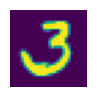

In [385]:
show_image(three_tensors[123]);

모든 이미지를 대상으로 각 픽셀 위치의 전체 평균을 계산하여 각 픽셀의 강도를 구하는 것이 목표였다. 그러려면 리스트 내의 모든 이미지를 3차원 텐서 하나로 결합해야한다. 일반적으로 3차원 텐서는 rank-3 텐서라고 함. 이렇게 컬렉션에 담긴 개별 텐서들을 쌓아 올려 단일 텐서를 만드는 일은 꽤 흔한 작업 패턴이다. 그래서 파이토치는 이 작업을 수행하는 stack이라는 함수를 제공한다.

평균 계산 등 파이토치가 제공하는 일부 연산은 정수 대신 부동소수형 데이터만을 지원하여, 작업에 따라 형 변환을 해야한다.

In [386]:
stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes = torch.stack(three_tensors).float() / 255
stacked_sevens.shape

torch.Size([6265, 28, 28])

In [387]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

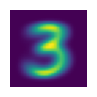

In [388]:
show_image(mean3);

<Axes: >

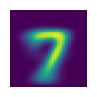

In [389]:
show_image(mean7)

In [390]:
stacked_threes.ndim

3

축이 3개라는 소리. 차원과 구별할 줄 알아야 함.

<Axes: >

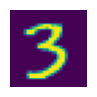

In [391]:
from random import randint

N = len(stacked_threes)

a_3 = stacked_threes[1]
show_image(a_3)

이상적인 숫자 3과의 거리를 어떻게 구할까?
1. 차이의 적댓값에 대한 평균을 구하는 (음수를 양수화) 방법. L1 노름 또는 평균절대차 (Mean Absolute Difference, MAD)라고 함.
1. 차이의 제곱(모든 수를 양수화 한다)에 대한 평균의 제굽근(제곱을 다시 원상태로 돌린다)을 구하는 방법. L2 노름 또는 평균제곱근오차 (Root Mean Squared Error, RMSE)라고 함.

In [392]:
# L1
dist_3_abs = (a_3 - mean3).abs().mean()
dist_7_abs = (a_3 - mean7).abs().mean()
dist_3_abs, dist_7_abs

(tensor(0.1114), tensor(0.1586))

In [393]:
# L2
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_3_sqr, dist_7_sqr

(tensor(0.2021), tensor(0.3021))

각 방법 모두에서 선택한 숫자 3 이미지는 '이상적인' 숫자 7보다 이상적인 숫자 3과의 거리가 더 짧습니다. 즉 간단히 만든 기준선 모델이 예측을 올바르게 수행했다고 볼 수 있다.
이것을 손실함수로 다시 측정해 보자.

In [394]:
from torch.nn.functional import l1_loss, mse_loss, cross_entropy, relu

l1_loss(a_3.float(), mean7), mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

결국 궁극적인 목표는 `is_3`라는 함수를 만들어 어떠한 이미지가 오더라도 3인지 7인지 구별할 수 있는 모델을 세우는것이다. 그렇게 하기 위해서는 두 이미지 사이의 거리를 계산해야 하므로, 거리의 개념부터 정의 해야함.

In [395]:
valid_3_tens = torch.stack(
    [tensor(Image.open(o)) for o in (path / 'valid' / '3').ls()]
)
valid_7_tens = torch.stack(
    [tensor(Image.open(o)) for o in (path / 'valid' / '7').ls()]
)

In [396]:
valid_3_tens = valid_3_tens.float() / 255
valid_7_tens = valid_7_tens.float() / 255

In [397]:
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [398]:
def mnist_distance(a, b): return (a - b).abs().mean((-1, -2))
mnist_distance(a_3, mean3), mnist_distance(a_3, mean7)

(tensor(0.1114), tensor(0.1586))

그런데 전체 이미지에 대한 평가지표를 계산하려면, 검증용 데이터셋 내 **모든** 이미지와 이상적인 숫자 3 이미지의 거리를 계산해야 한다.

In [399]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

In [400]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [401]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [402]:
# is_3(valid_3_dist)

In [403]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s) / 2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

이렇게 하면 꽤나 신뢰성 높은 함수를 얻을 수 있다.

하지만, 더 나은 결과를 얻으려면 실제로 무언가를 학습하는 시스템을 시도해야 함. 즉 시스템이 스스로 자동 수정해나가도록 하는 방법이 필요하다.
이를 SGD로 해결해 보자.

특정 이미지와 '이상적인 이미지' 사이의 유사도를 찾는 대신, 개별 픽셀마다 가중치를 설정하고 숫자를 표현하는 검은색 픽셀의 가중치를 높이는 방법을 생각해보자. 가령 숫자 7 이미지 우측 하단에 위치한 픽셀은 활성화 될 가능성이 매우 낮지만, 숫자 3 이미지라면 해당 부분이 높은 확률로 활성화됨. 따라서 이미지 우측 하단 픽셀들의 가중치는 숫자 7에서는 낮게, 숫자 3에서는 높게 매겨짐. 이 과정은 이미지 픽셀(x)과 각 픽셀에 대한 가중치(w)를 입력받는 함수로 표현할 수 있다. 가령 숫자 3이 될 확률은 아래와 같다.

In [404]:
def pr_three(pixels, weight): return (pixels * weight).sum()

# MNIST loss function

In [405]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)

In [406]:
train_y = tensor([1] * len(three_tensors) + [0] * len(seven_tensors)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [407]:
dset = list(zip(train_x, train_y))
x, y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [408]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28 * 28)
valid_y = tensor([1] * len(valid_3_tens) + [0] * len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

In [409]:
def init_params(size, std=1.0): return (torch.randn(size) * std).requires_grad_()
weights = init_params((28 * 28, 1))
weights

tensor([[-1.4363e-01],
        [ 7.3335e-01],
        [-5.6568e-01],
        [-5.3988e-01],
        [-9.3079e-02],
        [ 3.5860e-01],
        [-1.3683e+00],
        [-2.1692e-01],
        [ 8.1572e-01],
        [ 3.5471e-01],
        [ 1.6028e-01],
        [-1.7709e-01],
        [-1.7387e-01],
        [-4.9110e-01],
        [ 9.9980e-01],
        [-1.1114e+00],
        [ 2.2093e+00],
        [-9.8381e-01],
        [ 1.2464e+00],
        [ 1.1122e+00],
        [ 1.5487e-01],
        [ 8.0487e-02],
        [ 1.6432e-01],
        [-1.2014e+00],
        [ 6.2194e-01],
        [-1.3075e+00],
        [-2.5786e-01],
        [ 7.7622e-02],
        [ 1.3290e-01],
        [-2.3734e-01],
        [-2.8339e-01],
        [-2.3187e+00],
        [-1.1567e+00],
        [ 1.0145e+00],
        [-1.6940e+00],
        [ 1.2187e+00],
        [ 1.6009e+00],
        [ 2.5859e-01],
        [ 3.1066e-01],
        [-1.9245e+00],
        [ 3.9309e-01],
        [-7.6439e-01],
        [ 3.5328e-01],
        [ 3

In [410]:
bias = init_params(1)
bias

tensor([0.5714], requires_grad=True)

신경망에서는 `y = w * x + b` 방정식의 w를 가중치(weights), b를 편향이라고 함. 그리고 가중치와 편향을 모두 통틀어서 `parameter`라고 지칭함.

In [411]:
(train_x[0] * weights.T).sum() + bias

tensor([-2.3577], grad_fn=<AddBackward0>)

In [412]:
def linear1(xb): return xb @ weights + bias

In [413]:
preds = linear1(train_x)
preds

tensor([[ -2.3577],
        [-11.2726],
        [  4.7567],
        ...,
        [  6.9671],
        [  3.6508],
        [ -5.6937]], grad_fn=<AddBackward0>)

정확도를 검사하기 위해서 예측이 3인지 7인지 판단하려면 출력값이 0.5보다 큰지를 검사하면 된다.

In [414]:
corrects = (preds > 0.5).float() == train_y
corrects

tensor([[False],
        [False],
        [ True],
        ...,
        [False],
        [False],
        [ True]])

그리고 가중치 하나를 약간 바꿨을 때 정확도에 일어나는 변화를 실험해보자.

In [415]:
# weights[0] *= 1.0001

In [416]:
preds = linear1(train_x)
((preds > 0.5).float() == train_y).float().mean().item()

0.4565989077091217

(경사하강법 작동방식은 따로 참조)

SGD를 쓴다면 그라디언트를 계속해서 계산 할 수 밖에 없고 결국 0이 최적이니 더이상 계산이 일어나지 않는다.
그렇기 때문에 그 정확도 대신 약간 더 나은 예측을 도출한 가중치에 따라 약간 더 나은 손실을 계산하는 손실 함수가 필요함.

손실 함수는 이미지 자체가 아니라 모델 예측을 입력받는다. 따라서 이미지가 3인지에 대한 예측으로 0부터 1까지의 사잇값을 가지는 prds라는 한 인자를 정의함.
이 인자는 이미지로 색인된 벡터임.

손실 함수의 목적은 예측값과 참값 (target or label) 사이의 달므을 측정하는 것. 예측 인자는 앞서 언급했으므로, 이번에는 0 또는 1의 값을 가지는 `trgts`라는 인자를 정의함. 이 또한 이미지 별로 색인된 벡터임.

예를 들어 실제 정답이 3, 7, 3인 이미지 세장을 떠올려 보자. 모델은 높은 신뢰도 (0.9)로 첫번째 이미지가 3이고, 약간의 신뢰도(0.4)로 두번째 이미지가 7이라 예측했지만, 낮은 신뢰도(0.2)로 세번째 이미지가 7이라 틀리게 예측했다고 가정해 보겠습니다. 이때 손실 함수는 다음 6개의 값을 입력 받는다.

In [417]:
targets = tensor([1., 0., 1.])
predicts = tensor([0.9, 0.4, 0.2])

In [418]:
# 그리고 predictions와 targets 사이의 거리를 측정하는 손실 함수를 만든다.

def mnist_loss(predictions, targets):
    '''
    Exactly same with below python comprehension
    `[b[i] if a[i] else c[i] for i in range(len(a))]`
    
    This function returns the probability if the target is 1, otherwise returns 1 - probability (and normally would be 0).
    :param predictions: 
    :param targets: 
    :return: float and tensor
    '''
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

In [419]:
mnist_loss(predicts, targets)

tensor(0.4333)

In [420]:
# 손실율을 계산하는 함수이니 결과값이 줄어들 수록 당연히 좋은것이다.

mnist_loss(torch.tensor([1., 0., 1.]), targets)

tensor(0.)

하지만 이 함수는 결과 값이 0과 1사이에 반드시 포함된지는 않을 가능성이 있다. 그렇기 때문에 반드시 손실률을 0과 1사이로 제한하는 함수를 만들어야 한다.
sigmoid를 이용해 보자.

In [421]:
def sigmoid(x): return 1 / (1 + torch.exp(-x))

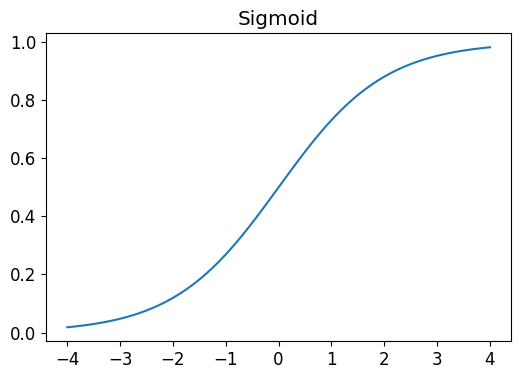

In [422]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [423]:
def mnist_loss(predictions, targets):
    '''
    이제 예측이 0과 1 사잇값이 아니더라도 손실 함수가 잘 작동한다고 확신할 수 있다. 단 하나의 전제 조건은 높은 예측값이 곧 높은 신뢰도로 연결된다는 사실이다.
    :param predictions: 
    :param targets: 
    :return: 
    '''
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1 - predictions, predictions).mean()

# 손실이 왜 필요한가

평가지표는 사람의 이해를 돕고, 손실은 자동화된 학습을 이끌어간다는 점이 주된 차이이다. 따라서 손실은 유의미한 미분이 있는 함수여야만 한다. 넓고 평평하거나 급작스러운 변화구간이 있어선 안되며, 적당히 매끄러운 형태를 띄어야만 한다. 앞서 구상했던 작은 신뢰도 변화에도 반응하는 손실 함수가 이런 특징을 수용한다. 손실 함수의 요구 사항은 사람이 정한 달성 목표를 정확히 반영하지는 못하지만, 달성 목표와 그레디언트로 최적화 될 수 있는 함수 사이의 절충안으로 볼 수 있다. 손실 함수는 데이터셋의 각 요소에 대해 계산되고, 한 에포크가 끝나는 시점에는 모든 손실값의 평균을 구할 수 있다.

반면 평가지표는 사람이 실제로 관심을 가지는 숫자이다. 매 에포크의 끝에서 모델이 얼마나 학습을 잘했는지를 알려주는 값이다. 

## 손실보다는 평가지표로 모델의 성능을 판단해야 한다는 사실을 기억하자.

In [424]:
# 최적화 단계 (mini batch)

coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 2,  3, 10, 11,  7]),
 tensor([ 5,  0, 13,  4,  9]),
 tensor([ 8,  6,  1, 12, 14])]

In [425]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [426]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 22, 19,  4, 13, 18]), ('r', 'w', 't', 'e', 'n', 's')),
 (tensor([ 6,  7, 24, 23, 16,  5]), ('g', 'h', 'y', 'x', 'q', 'f')),
 (tensor([21, 20, 12, 14,  8, 15]), ('v', 'u', 'm', 'o', 'i', 'p')),
 (tensor([10,  1, 25,  2,  3,  0]), ('k', 'b', 'z', 'c', 'd', 'a')),
 (tensor([ 9, 11]), ('j', 'l'))]

In [427]:
# for x, y in dl:
#     pred = model(x)
#     loss = mse_loss(pred, y)
#     loss.backward()
#     parameters -= parameters.grad * lr

In [428]:
weights = init_params((28 * 28, 1))
bias = init_params(1)

In [429]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [430]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [431]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [432]:
preds = linear1(batch)
preds

tensor([[24.9731],
        [14.1014],
        [11.4445],
        [26.4495]], grad_fn=<AddBackward0>)

In [433]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(2.8610e-06, grad_fn=<MeanBackward0>)

In [434]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-4.1018e-07), tensor([-2.8610e-06]))

In [435]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [436]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-8.2037e-07), tensor([-5.7220e-06]))

In [437]:
# 같은 코드를 두번 실행하면 그라디언트가 누적된다. 그래서 그라디언트를 0으로 초기화 해야한다.

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-1.2306e-06), tensor([-8.5830e-06]))

In [438]:
weights.grad.zero_()
bias.grad.zero_()

tensor([0.])

In [439]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()

In [440]:
(preds > 0.5).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [441]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [442]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [443]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.5266

In [444]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7572

In [445]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8735 0.9282 0.9496 0.9604 0.9648 0.9662 0.9687 0.9687 0.9706 0.9716 0.9726 0.9731 0.9736 0.9741 0.9741 0.9741 0.9741 0.9745 0.9745 0.9745 

## 옵티마이저

In [446]:
linear_model = nn.Linear(28 * 28, 1)

In [447]:
w, b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [448]:
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

In [449]:
opt = BasicOptim(linear_model.parameters(), lr)

In [450]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [451]:
validate_epoch(linear_model)

0.4663

In [452]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [453]:
train_model(linear_model, 20)

0.4932 0.873 0.8232 0.9106 0.9321 0.9468 0.9546 0.9624 0.9658 0.9668 0.9692 0.9721 0.9731 0.9751 0.9756 0.9761 0.9775 0.978 0.978 0.9785 

In [454]:
linear_model = nn.Linear(28 * 28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8169 0.8418 0.9116 0.935 0.9477 0.9565 0.9624 0.9663 0.9678 0.9692 0.9712 0.9726 0.9746 0.9761 0.9765 0.9775 0.9775 0.978 0.978 

In [455]:
dls = DataLoaders(dl, valid_dl)

In [456]:
learn = Learner(dls, nn.Linear(28 * 28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

In [457]:
learn.fit(10, lr=lr)

## 비선형성 추가

지금까지 함수의 파라미터를 최적화하는 일반적인 과정과 (약간은 지루한) 단순 선형 분류 모델을 구현한 함수를 시도해봤음. 선형 분류 모델이 한 수 있는 일에는 한계가 있습니다. 좀 더 복잡한 일을 다루려면 분류 모델을 좀 더 복잡하게 바꿔줘야 함. 두 선형 분류 모델 (계층) 사이에 비선형(ax+b와 다름)을 추가하면 됨. 그리고 이 형태가 바로 신경망이기도 함.

In [458]:
def simple_net(xb):
    res = xb @ w1 + b1
    res = res.max(tensor(0.0)) # LeRU
    res = res @ w2 + b2
    return res

In [459]:
w1 = init_params((28 * 28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)

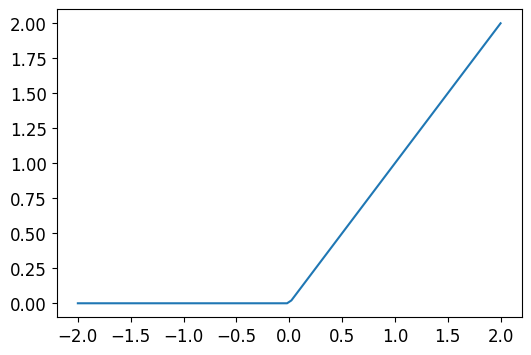

In [460]:
plot_function(relu)

기본적인 개념은 선형 계층을 더 많이 사용하여 모델이 계싼을 더 많이 수행하도록 만드는 것이다. 
즉, 더 복잡한 함수를 모델링 하는것이다. 그러나 한 선형 계층 다음에 또 다른 선형 계층을 배치하는 일에는 큰 의미가 없다.
곱셈과 덧셈을 여러 번 수행하면 사실상 한 선형 계층이 수행하는 한 번의 곱셈 및 덧셈과 다를 바가 없기 때문이다.
이는 순차적으로 배치된 여러 선형 계층은 다른 종류의 파라미터로 구성된 하나의 선형 계층으로 대체할 수 있다는 말이다.

하지만 선형 계층들 사이에 max와 같은 비선형 함수를 넣으면 상황이 달라진다. 각 선형 계층이 서로 분리되어 각각 자신만의 유용한 일을 할 수 있게 된다. 
max 함수가 특히 흥미로운 이유는 간단한 if 조건만으로도 작동을 하기 때문이다.

수학적으로 두 선형 함수의 조합은 또 다른 선형 함수이다. 
따라서 원하는 만큼 선형 함수를 차례대로 쌓아 올릴 수 있고 중간에 비선형 함수가 추가되지 않는다면, 이는 단순히 선형 함수 하나와 같다고 볼 수 있다.

## 일반근사정리
w1, w2를 충분히 큰 행렬로 구성하고 행렬의 올바른 값을 찾을 수만 있다면, 이 단순한 함수는 모든 계산 가능한 문제를 높은 정확도로 풀어낸다는 점을 수학적으로 증명할 수 있다.

다음 코드는 여러 계층을 표현한다. 첫번째와 세번째는 선형 계층, 두번째는 비선형성 또는 활성화 함수이다. 

In [461]:
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [462]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)
learn.fit(40, 0.1)

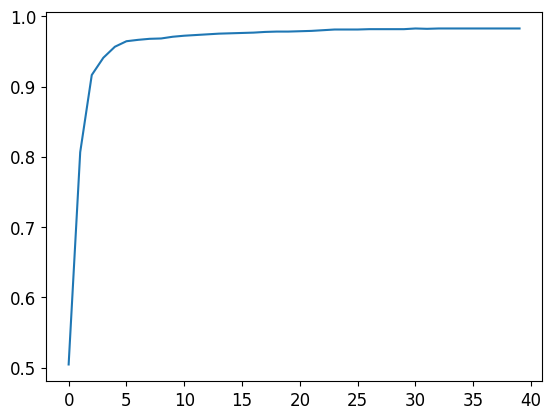

In [463]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [464]:
learn.recorder.values[-1][2]

0.982826292514801

여기서 마법이라고 할만한 결과
* 올바른 파나미터 집합이 주어지면 모든 문제를 원하는 정확도로 풀어낼 수 있는 함수(신경망)
* 모든 함수에 대한 최적의 파라미터 집합을 찾아내는 방법 (SGD)

이 두 가지가 딥러닝이 환상적인 일을 해낼 수 있는 이유이다. 이 간단한 두 기법의 결합이 모든 문제를 해결할 수 있다는 믿음은 딥러닝을 배우는 학생들이 취해야 할 큰 도약이다.
사실이라고 보기엔 너무 좋아 보인다. 더 복잡하고 어려운 무언가가 있어야 할것 같지만 일단 시도해보라고 말하고 싶다. MNIST 데이터셋에 대한 결과를 직접 확인 했다.
gradient 게싼을 제외한 모두를 직접 밑바닥부터 만들었으니 내부적으로 딱히 마법과도 같은 일이 일어나지 않는다는 사실을 알 수 있었다.

In [466]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False, loss_func=cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)